In [1]:
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm

#tensorflow deep learning basics
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L

#for model evaluation
from sklearn.model_selection import train_test_split, KFold,  StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
y_train = pd.read_csv('../input/kyivstar-bigdata-2020/train.csv')
sample_sub = pd.read_csv('../input/kyivstar-bigdata-2020/test.csv')
tabular_data = pd.read_csv('../input/kyivstar-bigdata-2020/tabular_data.csv')
id_ = tabular_data.id
hashed_feature = pd.read_csv('../input/kyivstar-bigdata-2020/hashed_feature.csv')

In [3]:
test_set = tabular_data.iloc[0:4084,:].groupby('id').count().reset_index()
test_set

,id,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,12,12,12,12,12,12,12,12,0,...,12,12,12,12,12,12,11,12,12,12
1,1,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,11,12,0,12
2,2,12,12,12,1,12,12,12,12,0,...,12,12,12,12,12,12,11,12,12,12
3,3,12,3,3,2,3,3,3,1,3,...,3,12,3,3,3,3,3,3,3,3
4,4,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,11,12,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,336,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,11,12,12,12
337,337,12,12,12,12,12,12,12,12,12,...,0,12,12,12,12,12,11,12,12,12
338,338,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,11,12,12,12
339,339,12,12,12,0,12,12,12,12,12,...,12,12,12,12,12,12,11,12,12,12


In [4]:
tabular_data = tabular_data.fillna(tabular_data.mean())
tabular_data = tabular_data.drop(['feature_41'], axis = 1)
tabular_data.shape

(61272, 51)

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
tabular_data.feature_25 = pd.Series(le.fit_transform(tabular_data.feature_25))

In [6]:
feats = tabular_data.columns
tabular_tensor = np.array(list(tabular_data.groupby('id').apply(lambda x: x[feats[1:]].values)))
tabular_tensor.shape

(5106, 12, 50)

In [7]:
train_inputs = tabular_tensor[0:4084,:,:].astype(np.float32)
test_inputs = tabular_tensor[4084:,:,:].astype(np.float32)
train_labels = y_train.target.values.astype(np.float32)

In [8]:
train_inputs.shape, test_inputs.shape, train_labels.shape

((4084, 12, 50), (1022, 12, 50), (4084,))

In [9]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(tpu_strategy)

In [10]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)


def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def build_model(model_type=1,seq_len=12, pred_len=12, dropout=0.5,hidden_dim=256):
    
    with tpu_strategy.scope():
    
        inputs = tf.keras.layers.Input(shape=(seq_len, 50))
        
        norm = tf.keras.layers.BatchNormalization()(inputs)

        reshaped = norm#tf.keras.layers.SpatialDropout1D(.2)(norm)

        if model_type == 0:
            hidden = gru_layer(hidden_dim, dropout)(reshaped)
            hidden = gru_layer(hidden_dim, dropout)(hidden)
            hidden = gru_layer(hidden_dim, dropout)(hidden)

        elif model_type == 1:
            hidden = lstm_layer(hidden_dim, dropout)(reshaped)
            hidden = lstm_layer(hidden_dim, dropout)(hidden)
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

        elif model_type == 2:
            hidden = gru_layer(hidden_dim, dropout)(reshaped)
            hidden = lstm_layer(hidden_dim, dropout)(hidden)
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

        elif model_type == 3:
            hidden = lstm_layer(hidden_dim, dropout)(reshaped)
            hidden = gru_layer(hidden_dim, dropout)(hidden)
            hidden = gru_layer(hidden_dim, dropout)(hidden)

        elif model_type == 4:
            hidden = lstm_layer(hidden_dim, dropout)(reshaped)
            hidden = gru_layer(hidden_dim, dropout)(hidden)
            hidden = lstm_layer(hidden_dim, dropout)(hidden)

        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
        out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
        model = tf.keras.Model(inputs=inputs, outputs=out)

        adam = tf.optimizers.Adam()
        model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

        return model

Model: model_1
Fold: 1
Epoch 1/40
52/52 - 8s - accuracy: 0.7165 - loss: 0.5689 - val_accuracy: 0.7392 - val_loss: 0.6426 - lr: 0.0010
Epoch 2/40
52/52 - 2s - accuracy: 0.7451 - loss: 0.5327 - val_accuracy: 0.7272 - val_loss: 0.6517 - lr: 0.0010
Epoch 3/40
52/52 - 2s - accuracy: 0.7502 - loss: 0.5248 - val_accuracy: 0.5142 - val_loss: 0.6862 - lr: 0.0010
Epoch 4/40
52/52 - 2s - accuracy: 0.7453 - loss: 0.5270 - val_accuracy: 0.5875 - val_loss: 0.6645 - lr: 0.0010
Epoch 5/40
52/52 - 2s - accuracy: 0.7476 - loss: 0.5205 - val_accuracy: 0.7536 - val_loss: 0.5189 - lr: 0.0010
Epoch 6/40
52/52 - 2s - accuracy: 0.7468 - loss: 0.5243 - val_accuracy: 0.7705 - val_loss: 0.5329 - lr: 0.0010
Epoch 7/40
52/52 - 2s - accuracy: 0.7494 - loss: 0.5174 - val_accuracy: 0.7596 - val_loss: 0.5153 - lr: 0.0010
Epoch 8/40
52/52 - 2s - accuracy: 0.7527 - loss: 0.5134 - val_accuracy: 0.7745 - val_loss: 0.5113 - lr: 0.0010
Epoch 9/40
52/52 - 2s - accuracy: 0.7600 - loss: 0.5116 - val_accuracy: 0.7762 - val_loss

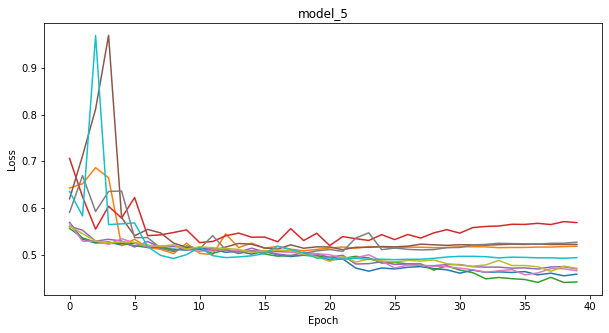

Model: model_2
Fold: 1
Epoch 1/40
52/52 - 9s - accuracy: 0.7388 - loss: 0.5528 - val_accuracy: 0.7368 - val_loss: 0.6096 - lr: 0.0010
Epoch 2/40
52/52 - 2s - accuracy: 0.7464 - loss: 0.5253 - val_accuracy: 0.4742 - val_loss: 0.6941 - lr: 0.0010
Epoch 3/40
52/52 - 2s - accuracy: 0.7523 - loss: 0.5283 - val_accuracy: 0.7368 - val_loss: 0.5686 - lr: 0.0010
Epoch 4/40
52/52 - 2s - accuracy: 0.7535 - loss: 0.5194 - val_accuracy: 0.7368 - val_loss: 0.5573 - lr: 0.0010
Epoch 5/40
52/52 - 2s - accuracy: 0.7580 - loss: 0.5145 - val_accuracy: 0.7394 - val_loss: 0.5411 - lr: 0.0010
Epoch 6/40
52/52 - 2s - accuracy: 0.7522 - loss: 0.5159 - val_accuracy: 0.7471 - val_loss: 0.5477 - lr: 0.0010
Epoch 7/40
52/52 - 2s - accuracy: 0.7579 - loss: 0.5065 - val_accuracy: 0.7385 - val_loss: 0.5292 - lr: 0.0010
Epoch 8/40
52/52 - 2s - accuracy: 0.7657 - loss: 0.5014 - val_accuracy: 0.7490 - val_loss: 0.5200 - lr: 0.0010
Epoch 9/40
52/52 - 2s - accuracy: 0.7599 - loss: 0.5046 - val_accuracy: 0.7760 - val_loss

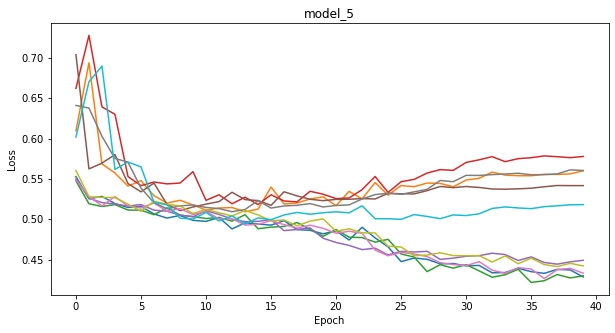

Model: model_3
Fold: 1
Epoch 1/40
52/52 - 9s - accuracy: 0.7343 - loss: 0.5530 - val_accuracy: 0.4139 - val_loss: 0.7067 - lr: 0.0010
Epoch 2/40
52/52 - 2s - accuracy: 0.7408 - loss: 0.5294 - val_accuracy: 0.7564 - val_loss: 0.6514 - lr: 0.0010
Epoch 3/40
52/52 - 2s - accuracy: 0.7514 - loss: 0.5176 - val_accuracy: 0.7377 - val_loss: 0.6292 - lr: 0.0010
Epoch 4/40
52/52 - 2s - accuracy: 0.7540 - loss: 0.5244 - val_accuracy: 0.7391 - val_loss: 0.5587 - lr: 0.0010
Epoch 5/40
52/52 - 2s - accuracy: 0.7479 - loss: 0.5186 - val_accuracy: 0.7368 - val_loss: 0.5504 - lr: 0.0010
Epoch 6/40
52/52 - 2s - accuracy: 0.7556 - loss: 0.5161 - val_accuracy: 0.7402 - val_loss: 0.5407 - lr: 0.0010
Epoch 7/40
52/52 - 2s - accuracy: 0.7527 - loss: 0.5196 - val_accuracy: 0.7385 - val_loss: 0.5427 - lr: 0.0010
Epoch 8/40
52/52 - 2s - accuracy: 0.7606 - loss: 0.5046 - val_accuracy: 0.7439 - val_loss: 0.5202 - lr: 0.0010
Epoch 9/40
52/52 - 2s - accuracy: 0.7594 - loss: 0.5072 - val_accuracy: 0.7620 - val_loss

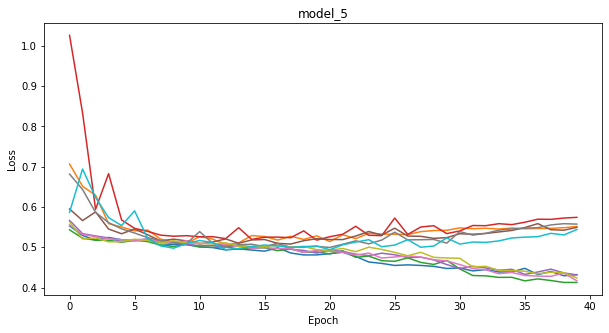

Model: model_4
Fold: 1
Epoch 1/40
52/52 - 9s - accuracy: 0.7308 - loss: 0.5539 - val_accuracy: 0.7368 - val_loss: 0.5910 - lr: 0.0010
Epoch 2/40
52/52 - 2s - accuracy: 0.7435 - loss: 0.5367 - val_accuracy: 0.7368 - val_loss: 0.5624 - lr: 0.0010
Epoch 3/40
52/52 - 2s - accuracy: 0.7371 - loss: 0.5341 - val_accuracy: 0.7254 - val_loss: 0.6424 - lr: 0.0010
Epoch 4/40
52/52 - 2s - accuracy: 0.7510 - loss: 0.5178 - val_accuracy: 0.5262 - val_loss: 0.7001 - lr: 0.0010
Epoch 5/40
52/52 - 2s - accuracy: 0.7565 - loss: 0.5174 - val_accuracy: 0.2942 - val_loss: 0.8145 - lr: 0.0010
Epoch 6/40
52/52 - 2s - accuracy: 0.7537 - loss: 0.5062 - val_accuracy: 0.7586 - val_loss: 0.5276 - lr: 0.0010
Epoch 7/40
52/52 - 2s - accuracy: 0.7486 - loss: 0.5160 - val_accuracy: 0.7579 - val_loss: 0.5321 - lr: 0.0010
Epoch 8/40
52/52 - 2s - accuracy: 0.7547 - loss: 0.5135 - val_accuracy: 0.7734 - val_loss: 0.5194 - lr: 0.0010
Epoch 9/40
52/52 - 2s - accuracy: 0.7576 - loss: 0.5048 - val_accuracy: 0.7538 - val_loss

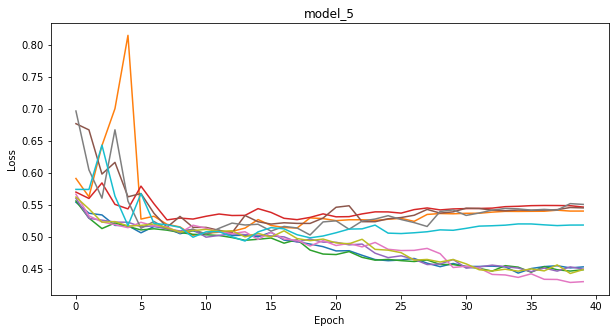

Model: model_5
Fold: 1
Epoch 1/40
52/52 - 9s - accuracy: 0.7249 - loss: 0.5514 - val_accuracy: 0.7368 - val_loss: 0.5720 - lr: 0.0010
Epoch 2/40
52/52 - 2s - accuracy: 0.7427 - loss: 0.5346 - val_accuracy: 0.7326 - val_loss: 0.6514 - lr: 0.0010
Epoch 3/40
52/52 - 2s - accuracy: 0.7519 - loss: 0.5212 - val_accuracy: 0.7368 - val_loss: 0.5625 - lr: 0.0010
Epoch 4/40
52/52 - 2s - accuracy: 0.7453 - loss: 0.5278 - val_accuracy: 0.7368 - val_loss: 0.5606 - lr: 0.0010
Epoch 5/40
52/52 - 2s - accuracy: 0.7553 - loss: 0.5165 - val_accuracy: 0.7391 - val_loss: 0.5900 - lr: 0.0010
Epoch 6/40
52/52 - 2s - accuracy: 0.7618 - loss: 0.5131 - val_accuracy: 0.7400 - val_loss: 0.5397 - lr: 0.0010
Epoch 7/40
52/52 - 2s - accuracy: 0.7611 - loss: 0.5127 - val_accuracy: 0.7590 - val_loss: 0.5123 - lr: 0.0010
Epoch 8/40
52/52 - 2s - accuracy: 0.7585 - loss: 0.5131 - val_accuracy: 0.7642 - val_loss: 0.5051 - lr: 0.0010
Epoch 9/40
52/52 - 2s - accuracy: 0.7570 - loss: 0.5059 - val_accuracy: 0.7540 - val_loss

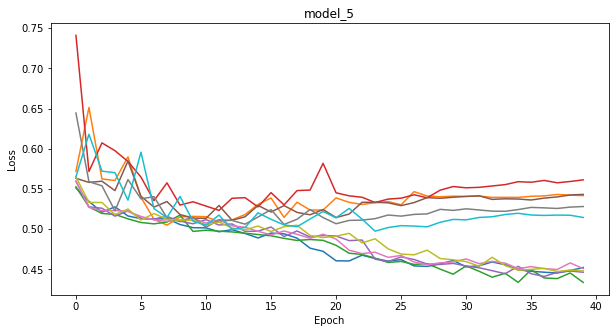

In [11]:
ensembles_by_fold = []
ensembles_full = []
n_folds=5; epochs=40; debug = True
for ii in range(5):
    model_type=ii
    model_name = "model_"+str(ii+1)
    print("Model:", model_name)
    ensemble_preds = pd.DataFrame(index=test_set.index, columns=['target']).fillna(0) # test dataframe with 0 values
    kf = KFold(n_folds, shuffle=True, random_state=42)
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=42)
    val_losses = []
    historys = []
    val_roc = []

    for i, (train_index, val_index) in enumerate(skf.split(train_inputs, train_labels)):
        print("Fold:", str(i+1))

        model_train = build_model(model_type=model_type, seq_len=12, pred_len=12)
        model_test = build_model(model_type=model_type, seq_len=12, pred_len=12)

        train_inputs1, train_labels1 = train_inputs[train_index], train_labels[train_index]
        
        val_inputs, val_labels = train_inputs[val_index], train_labels[val_index]

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5')

        history = model_train.fit(
            train_inputs1 , train_labels1, 
            validation_data=(val_inputs,val_labels),
            batch_size=64,
            epochs=epochs, # changed 70
#            callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule),checkpoint],
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau(), checkpoint],

            verbose=2 if debug else 0
        )
        
        print(f"{model_name} Min training loss={min(history.history['loss'])}, min validation loss={min(history.history['val_loss'])}")

        #val_roc.append()
        val_losses.append(min(history.history['val_loss']))
        historys.append(history)

        model_train.load_weights(f'{model_name}.h5')
        preds = model_test.predict(test_inputs)
        preds = preds[0:1022,:,:]
        ensembles_by_fold.append(preds)
        

        del train_inputs1, train_labels1, val_inputs, val_labels
        gc.collect()

    print("Mean Validation loss:", str(np.mean(val_losses)))
    gc.collect()
     

    if debug:
        fig, ax = plt.subplots(1, 1, figsize = (10, 5))
        for i, history in enumerate(historys):
            ax.plot(history.history['loss'])
            ax.plot(history.history['val_loss'])
            ax.set_title('model_'+str(i+1))
            ax.set_ylabel('Loss')
            ax.set_xlabel('Epoch')
        plt.show()
        


In [12]:
a = []
for i in ensembles_by_fold:
    a.append(np.mean(i, axis =1))
    
b = np.concatenate(a, axis=1)
print(b.shape)

sample_sub['score'] = np.mean(b, axis=1)
sample_sub

(1022, 25)


,id,score
0,4084,0.510339
1,4085,0.492422
2,4086,0.507109
3,4087,0.515549
4,4088,0.510034
...,...,...
1017,5101,0.518642
1018,5102,0.518692
1019,5103,0.521535
1020,5104,0.508123


In [13]:
sample_sub.to_csv('rnn_sub.csv', index=False)